In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

In [5]:
hdf5_filename = "test_results.h5"

channel_index = 0

num_time_samples = 5000  

Shape von 'time_data': (207360, 16)
Abtastrate: 44100.0 Hz


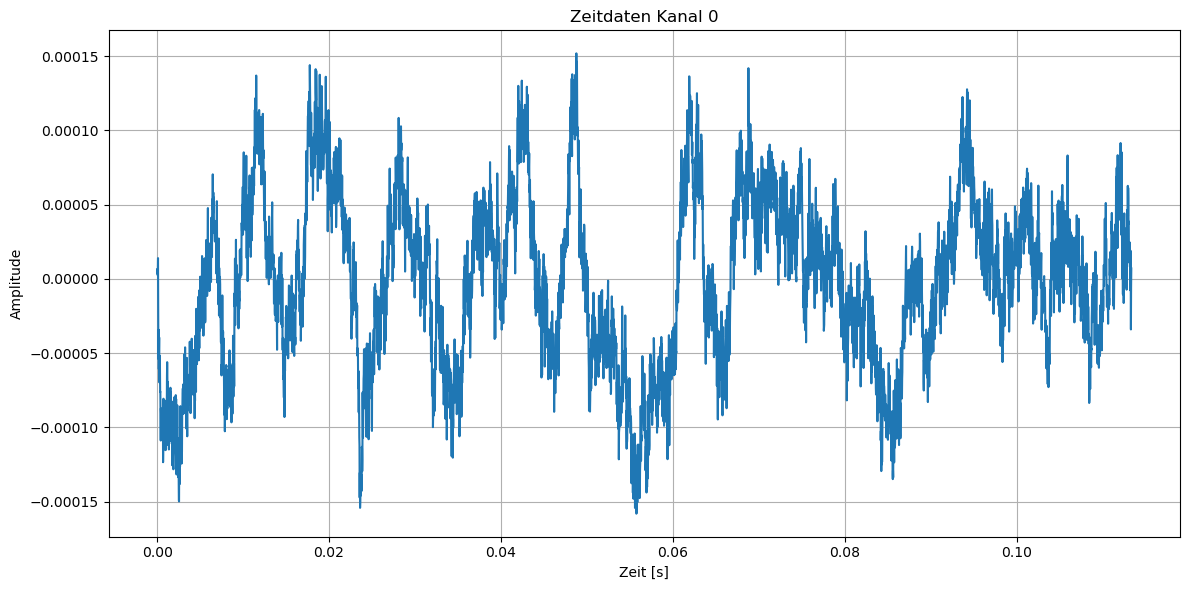

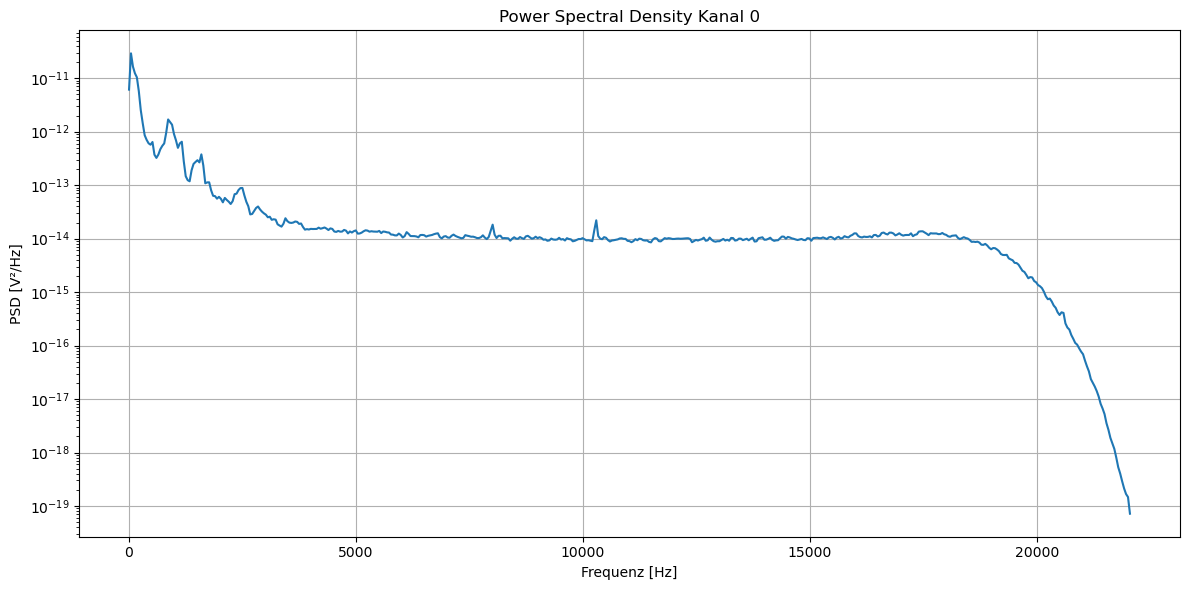

In [6]:

with h5py.File(hdf5_filename, 'r') as hdf5_file:

    time_data = hdf5_file['time_data']
    sample_freq = time_data.attrs['sample_freq']

    print(f"Shape von 'time_data': {time_data.shape}")
    print(f"Abtastrate: {sample_freq} Hz")
    
    channel_data = time_data[:, channel_index]
    
    num_samples = min(num_time_samples, channel_data.shape[0])
    time_vector = np.arange(num_samples) / sample_freq
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_vector, channel_data[:num_samples])
    plt.xlabel('Zeit [s]')
    plt.ylabel('Amplitude')
    plt.title(f'Zeitdaten Kanal {channel_index}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    freqs, psd = welch(channel_data, fs=sample_freq, nperseg=1024)
 
    plt.figure(figsize=(12, 6))
    plt.semilogy(freqs, psd)
    plt.xlabel('Frequenz [Hz]')
    plt.ylabel('PSD [V²/Hz]')
    plt.title(f'Power Spectral Density Kanal {channel_index}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()